## random reference
## random constraint
## only tracking (no constraint)

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


# read data

In [2]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
print(df_all.shape)
print(df_all.columns)

nan_rows = df_all[df_all.isna().any(axis=1)]

df_all = df_all.dropna()

loc_X = df_all["X"].to_numpy().reshape(-1,1)
loc_Y = df_all["Y"].to_numpy().reshape(-1,1)
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
# dist_Z = df_all["Dist_to_nearest_Z"].to_numpy()[::2].reshape(-1,1)
scan_spd = df_all["scanning_speed"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)
laser_on_off = df_all["laser_power_number"].to_numpy().reshape(-1,1)

# apply moving average for mp temp
mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

# apply moving average for mp depth
mp_depth_raw = df_all["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv
mp_depth = mp_depth.reshape(-1,1)       


(610615, 12)
Index(['time_index', 'melt_pool_temperature', 'melt_pool_depth',
       'scanning_speed', 'X', 'Y', 'Z', 'Dist_to_nearest_X',
       'Dist_to_nearest_Y', 'Dist_to_nearest_Z', 'Laser_power',
       'laser_power_number'],
      dtype='object')


## normalize

In [3]:
# stack input array
x_original_scale = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)
y_original_scale = np.concatenate((mp_temp, mp_depth), axis=1)

# scaling
x_max = np.max(x_original_scale,0).reshape(1,-1)
x_min = np.min(x_original_scale,0).reshape(1,-1) 
y_max = np.max(y_original_scale,0).reshape(1,-1) 
y_min = np.min(y_original_scale,0).reshape(1,-1)

print("x_max:", np.round(x_max, 3).tolist())
print("x_min:", np.round(x_min, 3).tolist())
print("y_max:", np.round(y_max, 3).tolist())
print("y_min:", np.round(y_min, 3).tolist())

x_max: [[7.5, 20.0, 20.0, 732.298]]
x_min: [[0.0, 0.75, 0.75, 504.26]]
y_max: [[4509.855, 0.551]]
y_min: [[436.608, -0.559]]


In [4]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [5]:
scaler = scalers(x_max, x_min, y_max, y_min)

x_s = scaler.scaler_x(x_original_scale)
y_s = scaler.scaler_y(y_original_scale)

print("x_s range:", np.min(x_s), "to", np.max(x_s))
print("y_s range:", np.min(y_s), "to", np.max(y_s))

print("x_s shape:", x_s.shape)
print("y_s shape:", y_s.shape)

x_s range: -1.0 to 1.0
y_s range: -1.0 to 1.0
x_s shape: (610417, 4)
y_s shape: (610417, 2)


## generate data

In [6]:
length = y_s.shape[0]

y_s_ref = np.random.uniform(0.0, 1.0, size=(length, 1))

e = 0.0001
y_depth_low = np.random.uniform(0.1423-e, 0.1423+e, size = (length,1))
y_depth_up = np.random.uniform(0.4126-e, 0.4126+e, size = (length,1))
# constraints!
#y_depth_low = 0*np.random.uniform(0.0, 0.5, size=(length, 1))
#y_depth_up = 0*np.random.uniform(0.5, 1.0, size=(length, 1))

y_s_const = np.concatenate((y_depth_low, y_depth_up), axis=1)

print("y_s_ref shape:", y_s_ref.shape)
print("y_s_const shape:", y_s_const.shape)

y_s_ref shape: (610417, 1)
y_s_const shape: (610417, 2)


## split data

In [7]:
# 기본 분할
cutoff_index = int(np.round(0.8 * x_s.shape[0]))
x_train, y_train = x_s[:cutoff_index], y_s[:cutoff_index]
x_val, y_val = x_s[cutoff_index:], y_s[cutoff_index:]
# y_ref_train, y_ref_val = y_s_ref[:cutoff_index], y_s_ref[cutoff_index:]
y_const_train, y_const_val = y_s_const[:cutoff_index], y_s_const[cutoff_index:]

window = 50
P = 50

# ------------------ Training set ------------------
n_train = cutoff_index - P - window
x_past_train = np.empty((n_train, window, 4))
y_past_train = np.empty((n_train, window, 2))
x_future_train = np.empty((n_train, P, 3))
y_ref_train_seq = np.empty((n_train, P, 1))
y_const_train_seq = np.empty((n_train, P, 2))

for i in tqdm(range(window, cutoff_index - P)):
    j = i - window
    x_past_train[j] = x_train[i-window:i]

    # shift for u past last component
    #u_last_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
    #x_past_train[j, -1, 3] += u_last_shift

    y_past_train[j] = y_train[i-window:i]
    x_future_train[j] = x_train[i:i+P, :3]         

    # shift for temp future entire horizon
    # scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()  # Random scalar shift for y_ref
    # y_ref_train_seq[j] = y_train[i:i+P, :1] + scalar_shift
    # y_ref_train_seq[j] = y_ref_train[i:i+P]

    # 조건에 따라 다른 범위의 shift 적용(0801)
    if y_train[i, 0].item() < 0.3:
        scalar_shift = torch.empty(1).uniform_(-0.0001, 0.0001).item()
    else:
        scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()

    y_ref_train_seq[j] = y_train[i:i+P, :1] + scalar_shift

    y_const_train_seq[j] = y_const_train[i:i+P]

# ------------------ Validation set ------------------
val_cutoff = x_s.shape[0] - cutoff_index
n_val = val_cutoff - P - window
x_past_val = np.empty((n_val, window, 4))
y_past_val = np.empty((n_val, window, 2))
x_future_val = np.empty((n_val, P, 3))
y_ref_val_seq = np.empty((n_val, P, 1))
y_const_val_seq = np.empty((n_val, P, 2))

for i in tqdm(range(window, val_cutoff - P)):
    j = i - window
    x_past_val[j] = x_val[i-window:i]
    y_past_val[j] = y_val[i-window:i]
    x_future_val[j] = x_val[i:i+P, :3]

    # scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item() 
    # y_ref_val_seq[j] = y_val[i:i+P, :1] + scalar_shift
    # y_ref_val_seq[j] = y_ref_val[i:i+P]

    # 조건에 따라 다른 범위의 shift 적용 (0801)
    if y_val[i, 0].item() < 0.3:
        scalar_shift = torch.empty(1).uniform_(-0.0001, 0.0001).item()
    else:
        scalar_shift = torch.empty(1).uniform_(-0.1, 0.1).item()
    y_ref_val_seq[j] = y_val[i:i+P, :1] + scalar_shift


    y_const_val_seq[j] = y_const_val[i:i+P]

x_past_train = torch.tensor(x_past_train, dtype=torch.float32)
y_past_train = torch.tensor(y_past_train, dtype=torch.float32)
x_future_train = torch.tensor(x_future_train, dtype=torch.float32)
y_ref_train_seq = torch.tensor(y_ref_train_seq, dtype=torch.float32)
y_const_train_seq = torch.tensor(y_const_train_seq, dtype=torch.float32)

print("x_past shape : ", x_past_train.shape)       # (n_train, 50, 4)
print("y_past shape : ",y_past_train.shape)       # (n_train, 50, 2)
print("x_future shape : ",x_future_train.shape)     # (n_train, 50, 3)
print("y_ref shape : ",y_ref_train_seq.shape)    # (n_train, 50, 1)
print("y_const shape : ",y_const_train_seq.shape)  # (n_train, 50, 2)

x_past_val = torch.tensor(x_past_val, dtype=torch.float32)
y_past_val = torch.tensor(y_past_val, dtype=torch.float32)
x_future_val = torch.tensor(x_future_val, dtype=torch.float32)
y_ref_val_seq = torch.tensor(y_ref_val_seq, dtype=torch.float32)
y_const_val_seq = torch.tensor(y_const_val_seq, dtype=torch.float32)

print("x_past_val shape : ", x_past_val.shape)       # (n_val, 50, 4)
print("y_past_val shape : ", y_past_val.shape)       # (n_val, 50, 2)
print("x_future_val shape : ", x_future_val.shape)   # (n_val, 50, 3)
print("y_ref_val shape : ", y_ref_val_seq.shape)     # (n_val, 50, 1)
print("y_const_val shape : ", y_const_val_seq.shape) # (n_val, 50, 2)

100%|██████████| 121983/121983 [00:01<00:00, 96802.97it/s]


x_past shape :  torch.Size([488234, 50, 4])
y_past shape :  torch.Size([488234, 50, 2])
x_future shape :  torch.Size([488234, 50, 3])
y_ref shape :  torch.Size([488234, 50, 1])
y_const shape :  torch.Size([488234, 50, 2])
x_past_val shape :  torch.Size([121983, 50, 4])
y_past_val shape :  torch.Size([121983, 50, 2])
x_future_val shape :  torch.Size([121983, 50, 3])
y_ref_val shape :  torch.Size([121983, 50, 1])
y_const_val shape :  torch.Size([121983, 50, 2])


In [8]:
batch_size = 256
# Make sure your training/validation tensors are torch.Tensor before this line
train_dataset = TensorDataset(x_past_train, y_past_train, x_future_train, y_ref_train_seq, y_const_train_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_past_val, y_past_val, x_future_val, y_ref_val_seq, y_const_val_seq)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# loss function


In [9]:
## updated loss - not used

def DPC_loss(x_past: torch.Tensor, tide_output: torch.Tensor, reference: torch.Tensor, u_output: torch.Tensor, constraint: torch.Tensor,
             w_tracking=1.0, w_smooth=0, w_constraint=0):
    
    tide_output = tide_output.median(dim=-1).values
    tide_output_temp = tide_output[:, :, 0]  # temperature prediction
    reference = reference[:, :, 0]

    # ─── Clipped Tracking Loss ─────────────────────────────
    abs_error = torch.abs(reference - tide_output_temp)
    clipped_error = torch.clamp(abs_error, max=500.0)
    mask = (abs_error < 0.2).float()  # Only use small-error regions

    tracking_loss = (clipped_error ** 2) * mask

    # ─── Smoothness Loss ───────────────────────────────────
    u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
    smoothness_loss = u_diff ** 2

    # ─── Constraint Loss ───────────────────────────────────
    tide_output_depth = tide_output[:, :, 1]
    low_violation = torch.relu(constraint[:, :, 0] - tide_output_depth) ** 2
    up_violation = torch.relu(tide_output_depth - constraint[:, :, 1]) ** 2
    constraint_loss = up_violation  # or: + low_violation if needed

    # ─── Final Weighted Loss ───────────────────────────────
    loss = (
        w_tracking * torch.sqrt(tracking_loss.mean()) +
        w_smooth * torch.sqrt(smoothness_loss.mean()) +
        w_constraint * torch.sqrt(constraint_loss.mean())
    )
    return loss


In [10]:
def DPC_loss(x_past: torch.Tensor, tide_output: torch.Tensor, reference: torch.Tensor, u_output: torch.Tensor, constraint: torch.Tensor,
             w_tracking=1.0, w_smooth=0, w_constraint=0):
    
    tide_output = tide_output.median(dim=-1).values
    tide_output_temp = tide_output[:, :, 0]
    reference = reference[:, :, 0]
    tracking_loss = (reference - tide_output_temp) ** 2

    u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
    u_diff_2 = x_past[:, -1, 3] - u_output[:,   0, :] ## added for smoothness loss
    smoothness_loss = u_diff ** 2 
    smoothness_loss_2 = (1/50) * u_diff_2 ** 2

    tide_output_depth = tide_output[:, :, 1]
    low_violation = torch.relu(constraint[:, :, 0] - tide_output_depth) ** 2
    up_violation = torch.relu(tide_output_depth - constraint[:, :, 1]) ** 2
    constraint_loss = 0 * low_violation + up_violation

    loss = (
        w_tracking * torch.sqrt(tracking_loss.mean()) +
        w_smooth * (torch.sqrt(smoothness_loss.mean()) +torch.sqrt(smoothness_loss_2.mean())) +
        w_constraint * torch.sqrt(constraint_loss.mean())
    )
    return loss


In [11]:
def DPC_loss(x_past, tide_out, ref, u_out, constr,
             temp_th=0.3,
             w_tracking=1.0,
             w_smooth_low=3.0,
             w_smooth=1.0,
             w_constraint=1.0):

    # median across ensemble dim
    tide = tide_out.median(dim=-1).values      # [B, T, 2]
    tmp_pred = tide[..., 0]                    # [B, T]
    tmp_ref  = ref[..., 0]                     # [B, T]

    # tracking error squared
    se_track = (tmp_ref - tmp_pred).pow(2)     # [B, T]
    L_track = torch.sqrt(se_track.mean())

    # smoothness error squared
    du = u_out[:,1:,:] - u_out[:,:-1,:]        # [B, T-1, 1]
    se_smooth = du.pow(2)                     # [B, T-1, 1]

    # regime-based smoothness weight mask
    smooth_mask = torch.where(tmp_ref[:,:-1] < temp_th,
                              w_smooth_low,
                              1.0).unsqueeze(-1)  # [B, T-1, 1]
    weighted_smooth = se_smooth * smooth_mask
    L_smooth = torch.sqrt(weighted_smooth.mean())

    # constraint loss (upper bound only)
    depth = tide[..., 1]
    se_constr = torch.relu(depth - constr[..., 1]).pow(2)
    L_constr = torch.sqrt(se_constr.mean())

    # total loss
    loss = L_track + w_smooth * L_smooth + w_constraint * L_constr
    return loss, L_track.item(), L_smooth.item(), L_constr.item()


In [12]:
def DPC_loss(x_past: torch.Tensor, tide_output: torch.Tensor, reference: torch.Tensor, u_output: torch.Tensor, constraint: torch.Tensor,
             w_tracking=1.0, w_smooth=0, w_constraint=0):
    
    tide_output = tide_output.median(dim=-1).values
    tide_output_temp = tide_output[:, :, 0]
    reference = reference[:, :, 0]
    tracking_loss = (reference - tide_output_temp) ** 2

    # ─── Apply time-dependent Q weights (linearly decreasing) ───
    T = tracking_loss.shape[1]
    q_weights = torch.linspace(1.0, 1.0, T, device=tracking_loss.device)  # shape [T]
    q_weights = q_weights.unsqueeze(0)  # shape [1, T] for broadcasting
    tracking_loss = tracking_loss * q_weights  # shape [B, T]


    u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
    #u_diff_2 = x_past[:, -1, 3] - u_output[:,   0, :] ## added for smoothness loss
    smoothness_loss = u_diff ** 2 
    #smoothness_loss_2 = (1/50) * u_diff_2 ** 2

    tide_output_depth = tide_output[:, :, 1]
    low_violation = torch.relu(constraint[:, :, 0] - tide_output_depth) ** 2
    up_violation = torch.relu(tide_output_depth - constraint[:, :, 1]) ** 2
    constraint_loss = 0 * low_violation + up_violation

    L_tracking = torch.sqrt(tracking_loss.mean())
    L_smooth = torch.sqrt(smoothness_loss.mean()) #+ torch.sqrt(smoothness_loss_2.mean())
    L_constraint = torch.sqrt(constraint_loss.mean())

    loss = (
        w_tracking * L_tracking +
        w_smooth * L_smooth +
        w_constraint * L_constraint
    )

    return loss, L_tracking.item(), L_smooth.item(), L_constraint.item()


In [13]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())

In [14]:
import pickle
import os

def train_and_evaluate(n_layers, hidden_dim, setting_name,
                       w_smooth, w_constraint):
    model = PolicyNN(
        past_input_dim=6,
        future_input_dim=6,
        output_dim=1,
        p=50,
        window=50,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout_p=0.1
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.90)

    best_model = None
    best_val_loss = float("inf")
    save_train_loss = np.zeros(num_epoch)
    save_val_loss = np.zeros(num_epoch)
    counter = 0

    with tqdm(total=num_epoch, desc=setting_name) as pbar:
        model.train()

        save_train_tracking = np.zeros(num_epoch)
        save_train_smooth = np.zeros(num_epoch)
        save_train_constraint = np.zeros(num_epoch)

        save_val_tracking = np.zeros(num_epoch)
        save_val_smooth = np.zeros(num_epoch)
        save_val_constraint = np.zeros(num_epoch)

        for epoch in range(num_epoch):

            for x_past, y_past, x_future, y_ref, y_const in train_loader:
                x_past, y_past, x_future, y_ref, y_const = (
                    x_past.to(device), y_past.to(device),
                    x_future.to(device), y_ref.to(device), y_const.to(device)
                )

                policy_in_past = torch.cat((x_past, y_past), dim=2)
                policy_in_future = torch.cat((x_future, y_ref, y_const), dim=2)

                optimizer.zero_grad()

                u_output = model((policy_in_past, policy_in_future))
                x_future_tide = torch.cat((x_future, u_output), dim=2)
                past_cov = torch.cat((y_past, x_past), dim=2)

                tide_pred = TiDE((past_cov, x_future_tide, None))
                loss, l_track, l_smooth, l_const = DPC_loss(x_past, tide_pred, y_ref, u_output, y_const,
                                w_tracking=1.0, w_smooth=w_smooth, w_constraint=w_constraint)

                loss.backward()
                optimizer.step()

            # validation
            model.eval()
            val_loss_total = 0.0
            val_track_total = 0.0
            val_smooth_total = 0.0
            val_const_total = 0.0
            num_val_batches = 0


            with torch.no_grad():
                for val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const in val_loader:
                    val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const = (
                        val_x_past.to(device), val_y_past.to(device),
                        val_x_future.to(device), val_y_ref.to(device), val_y_const.to(device)
                    )

                    val_policy_in_past = torch.cat((val_x_past, val_y_past), dim=2)
                    val_policy_in_fut = torch.cat((val_x_future, val_y_ref, val_y_const), dim=2)

                    val_u_output = model((val_policy_in_past, val_policy_in_fut))

                    x_future_tide_val = torch.cat((val_x_future, val_u_output), dim=2)
                    past_cov_val = torch.cat((val_y_past, val_x_past), dim=2)

                    val_tide_pred = TiDE((past_cov_val, x_future_tide_val, None))
                    val_loss, val_l_track, val_l_smooth, val_l_const = DPC_loss(val_x_past, val_tide_pred, val_y_ref, val_u_output, val_y_const,
                                        w_tracking=1.0, w_smooth=w_smooth, w_constraint=w_constraint)

                    val_loss_total += val_loss.item()
                    val_track_total += val_l_track
                    val_smooth_total += val_l_smooth
                    val_const_total += val_l_const
                    num_val_batches += 1

            val_loss_avg = val_loss_total / num_val_batches
            val_track_avg = val_track_total / num_val_batches
            val_smooth_avg = val_smooth_total / num_val_batches
            val_const_avg = val_const_total / num_val_batches

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

            save_train_loss[epoch] = loss.item()
            save_val_loss[epoch] = val_loss_avg

            save_train_tracking[epoch] = l_track
            save_train_smooth[epoch] = l_smooth
            save_train_constraint[epoch] = l_const

            save_val_tracking[epoch] = val_track_avg
            save_val_smooth[epoch] = val_smooth_avg
            save_val_constraint[epoch] = val_const_avg

            scheduler.step()
            pbar.set_description(
                f"{setting_name} | Epoch {epoch} "
                f"| Train: {loss.item():.4f} (t={l_track:.3f}, s={l_smooth:.3f}, c={l_const:.3f}) "
                f"| Val: {val_loss_avg:.4f} (t={val_track_avg:.3f}, s={val_smooth_avg:.3f}, c={val_const_avg:.3f})"
            )
            pbar.update(1)


    # directory where you want to store all results
    train_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults"
    os.makedirs(train_dir, exist_ok=True)

    # build filename and full path
    model_filename = f"policy_model_discreteshift_final_{setting_name}.pth"
    model_path = os.path.join(train_dir, model_filename)

    # save and report
    torch.save(best_model, model_path)
    print(f"Saved model to: {model_path}")

    # Save model parameters as .pkl
    model_params = {
        "model_name": setting_name,
        "past_input_dim": 6,
        "future_input_dim": 6,
        "output_dim": 1,
        "future_cov_dim": 2,
        "static_cov_dim": 0,
        "window": 50,
        "p": 50,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "num_epoch": num_epoch,
        "w_smooth": w_smooth,
        "w_constraint": w_constraint
    }

    train_dir = "/home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults"
    os.makedirs(train_dir, exist_ok=True)

    # save model parameters
    param_filename = f"policy_parameters_discreteshift_final_{setting_name}.pkl"
    param_path = os.path.join(train_dir, param_filename)
    with open(param_path, "wb") as f:
        pickle.dump(model_params, f)
    print(f"Saved model parameters to: {param_path}")

    return {
        "train_loss": save_train_loss,
        "val_loss": save_val_loss,
        "train_tracking_loss": save_train_tracking,
        "train_smooth_loss": save_train_smooth,
        "train_constraint_loss": save_train_constraint,
        "val_tracking_loss": save_val_tracking,
        "val_smooth_loss": save_val_smooth,
        "val_constraint_loss": save_val_constraint
    }


In [15]:
import torch
import os
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pickle

# Hyperparameters
num_epoch = 100
learning_rate = 1e-3
weight_decay = 1e-5
patience = 100

target_configs = [
    (3, 32, 1, 3),
    (3, 64, 1, 3),
    (3, 128, 1, 3),
    (3, 256, 1, 3),
    (3, 512, 1, 3),
    (3, 1024, 1, 3)  # s0c0
]

# Results dictionary
results = {}

# Run training for each configuration
for n_layers, hidden_dim, w_smooth, w_constraint in target_configs:
    setting_name = f"{n_layers}L_{hidden_dim}H_s{w_smooth}_c{w_constraint}"
    print(f"\n▶ Training model: {setting_name}")

    result = train_and_evaluate(
        n_layers=n_layers,
        hidden_dim=hidden_dim,
        setting_name=setting_name,
        w_smooth=w_smooth,
        w_constraint=w_constraint
    )
    results[setting_name] = result



▶ Training model: 3L_32H_s1_c3


3L_32H_s1_c3 | Epoch 99 | Train: 0.1653 (t=0.134, s=0.012, c=0.006) | Val: 0.1286 (t=0.103, s=0.010, c=0.005): 100%|██████████| 100/100 [40:56<00:00, 24.57s/it]


Saved model to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_final_3L_32H_s1_c3.pth
Saved model parameters to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_parameters_discreteshift_final_3L_32H_s1_c3.pkl

▶ Training model: 3L_64H_s1_c3


3L_64H_s1_c3 | Epoch 99 | Train: 0.1488 (t=0.115, s=0.013, c=0.007) | Val: 0.1258 (t=0.103, s=0.011, c=0.004): 100%|██████████| 100/100 [38:59<00:00, 23.39s/it]


Saved model to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_final_3L_64H_s1_c3.pth
Saved model parameters to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_parameters_discreteshift_final_3L_64H_s1_c3.pkl

▶ Training model: 3L_128H_s1_c3


3L_128H_s1_c3 | Epoch 99 | Train: 0.1128 (t=0.088, s=0.011, c=0.004) | Val: 0.1258 (t=0.104, s=0.011, c=0.004): 100%|██████████| 100/100 [36:50<00:00, 22.10s/it]


Saved model to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_final_3L_128H_s1_c3.pth
Saved model parameters to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_parameters_discreteshift_final_3L_128H_s1_c3.pkl

▶ Training model: 3L_256H_s1_c3


3L_256H_s1_c3 | Epoch 99 | Train: 0.1494 (t=0.121, s=0.014, c=0.005) | Val: 0.1258 (t=0.104, s=0.011, c=0.004): 100%|██████████| 100/100 [37:11<00:00, 22.31s/it]


Saved model to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_final_3L_256H_s1_c3.pth
Saved model parameters to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_parameters_discreteshift_final_3L_256H_s1_c3.pkl

▶ Training model: 3L_512H_s1_c3


3L_512H_s1_c3 | Epoch 99 | Train: 0.1374 (t=0.109, s=0.014, c=0.005) | Val: 0.1225 (t=0.097, s=0.013, c=0.004): 100%|██████████| 100/100 [35:50<00:00, 21.50s/it]


Saved model to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_final_3L_512H_s1_c3.pth
Saved model parameters to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_parameters_discreteshift_final_3L_512H_s1_c3.pkl

▶ Training model: 3L_1024H_s1_c3


3L_1024H_s1_c3 | Epoch 99 | Train: 0.1203 (t=0.096, s=0.014, c=0.003) | Val: 0.1231 (t=0.100, s=0.013, c=0.003): 100%|██████████| 100/100 [35:30<00:00, 21.31s/it]

Saved model to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_model_discreteshift_final_3L_1024H_s1_c3.pth
Saved model parameters to: /home/ftk3187/github/DPC_research/02_DED/4_policy_0725/trainresults/policy_parameters_discreteshift_final_3L_1024H_s1_c3.pkl


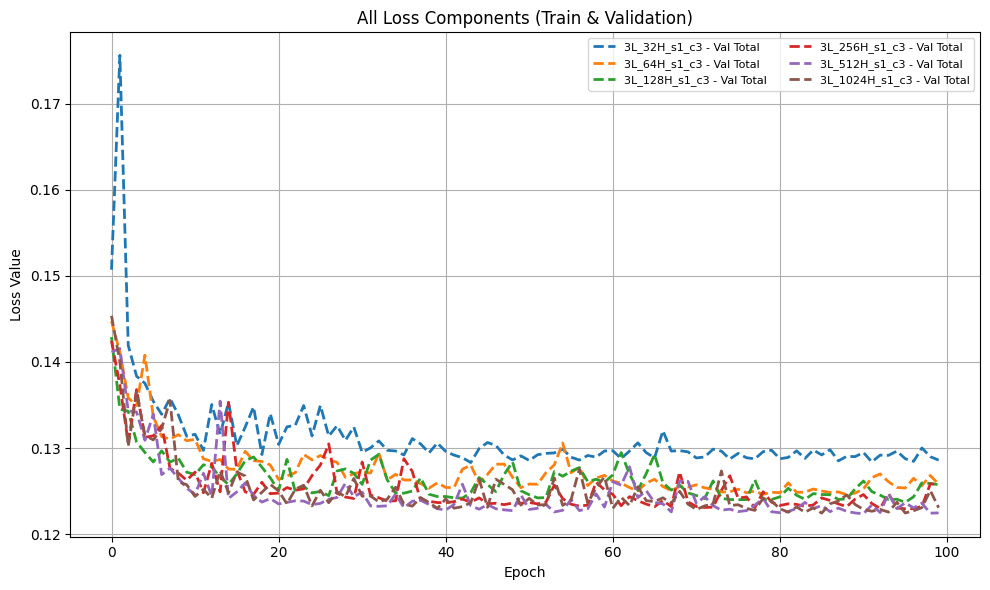

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for setting_name, result in results.items():
    # Total loss
    #plt.plot(result['train_loss'], label=f"{setting_name} - Train Total", linewidth=2)
    plt.plot(result['val_loss'], label=f"{setting_name} - Val Total", linestyle='--', linewidth=2)

    # Tracking loss
    #plt.plot(result['train_tracking_loss'], label=f"{setting_name} - Train Track", alpha=0.7)
    #plt.plot(result['val_tracking_loss'], label=f"{setting_name} - Val Track", linestyle='--', alpha=0.7)

    # Smoothness loss
    #plt.plot(result['train_smooth_loss'], label=f"{setting_name} - Train Smooth", alpha=0.7)
    #plt.plot(result['val_smooth_loss'], label=f"{setting_name} - Val Smooth", linestyle='--', alpha=0.7)

    # Constraint loss
    #plt.plot(result['train_constraint_loss'], label=f"{setting_name} - Train Const", alpha=0.7)
    #plt.plot(result['val_constraint_loss'], label=f"{setting_name} - Val Const", linestyle='--', alpha=0.7)

plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("All Loss Components (Train & Validation)")
plt.legend(loc="upper right", fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
